In [141]:
import random
import math


class Example():
    def __init__(self, path, reward):
        self.path = path
        self.reward = reward

    def __str__(self):
        return 'path: {} \t\t reward: {}'.format(self.path, self.reward)

    @classmethod
    def generate_example(cls):
        path = [2]
        while 'TERM' not in idx_to_state[path[-1]]:
            if random.random() > 0.5:
                path.append(path[-1] + 1)
            else:
                path.append(path[-1] - 1)
        path = [idx_to_state[i] for i in path]
        reward = 1 if path[-1] == 'RTERM' else 0
        return cls(path, reward)


class MarkovProcess():
    def __init__(self, states):
        self.states = states
        self.values = self.reset_values()

    def reset_values(self):
        values = {s: 0.5 for s in states}
        for val in values:
            if 'TERM' in val:
                values[val] = 0
        return values

    def move_right(self, state):
        return idx_to_state[state_to_idx[state] + 1]

    def move_left(self, state):
        return idx_to_state[state_to_idx[state] - 1]

    def value_prediction(self):
        raise NotImplementedError



class MarkovRewardProcess(MarkovProcess):
    def __init__(self, states):
        super().__init__(states)

    def expected_return(self, s, values):
        right_state = self.move_right(s)
        reward = 1 if right_state == 'RTERM' else 0
        left_state = self.move_left(s) # no reward
        ret = 0.5 * (reward + values[right_state]) +\
            0.5 * (0 + values[left_state])
        return ret

    def value_prediction(self):
        values = self.reset_values()
        while True:
            delta = 0.
            for s in self.states:
                if 'TERM' in s: continue
                old_v = values[s]
                values[s] = self.expected_return(s, values)
                delta = max(delta, abs(old_v - values[s]))
            if delta < 1e-4: break
        return values


class MonteCarlo(MarkovProcess):
    def __init__(self, states, alpha):
        super().__init__(states)
        self.alpha = alpha

    def value_prediction(self, n):
        values = self.reset_values()
        examples = [Example.generate_example() for _ in range(n)]
        for ex in examples:
            visited = []
            ret = ex.reward
            for s in ex.path[-2::-1]:
                if s not in visited:
                    values[s] = values[s] + self.alpha * (ret - values[s])
        return values


class TemporalDifference(MarkovProcess):
    def __init__(self, states, alpha):
        super().__init__(states)
        self.alpha = alpha

    def value_prediction(self, n):
        values = self.reset_values()
        examples = [Example.generate_example() for _ in range(n)]
        for ex in examples:
            for s, next_s in zip(ex.path[:-1], ex.path[1:]):
                reward = 1 if next_s == 'RTERM' else 0
                values[s] = values[s] +\
                    self.alpha * (reward + values[next_s]- values[s])
        return values


def root_mean_squared(values1, values2):
    ret = 0.
    for val1, val2 in zip(values1.values(), values2.values()):
        ret += math.sqrt((val1 - val2) ** 2)
    return ret / math.sqrt(len(values1))


if __name__ == "__main__":

    states = ['LTERM', 'A', 'B', 'C', 'D', 'E', 'RTERM']
    idx_to_state = {idx: state for idx, state in zip(range(-1, 6, 1), states)}
    state_to_idx = {state: idx for idx, state in idx_to_state.items()}
    num_examples = [0, 1, 10, 100]

    MRP = MarkovRewardProcess(states)
    values_MRP = MRP.value_prediction()

    values_MC = []
    MC = MonteCarlo(states, alpha=0.1)
    for n in num_examples:
        values_MC.append(MC.value_prediction(n))

    values_TD = []
    TD = TemporalDifference(states, alpha=0.1)
    for n in num_examples:
        values_TD.append(TD.value_prediction(n))

In [142]:
import matplotlib.pyplot as plt

In [143]:
def x_y_from_values(values):
    dic = {}
    for k, v in values.items():
        if 'TERM' in k: continue
        dic[k] = v
    return dic.keys(), dic.values()

In [149]:
# plt.figure(1, figsize=(7,7))
# plt.title('Monte Carlo with n= 0, 1, 10, 100', fontsize=20)
# plt.plot(*x_y_from_values(values_MRP), 'r', *x_y_from_values(values_MC[0]), 'b',
#         *x_y_from_values(values_MC[1]), 'g', *x_y_from_values(values_MC[2]), 'y',
#         *x_y_from_values(values_MC[3]), 'm')
# plt.xlabel('State', fontsize=15)
# plt.ylabel('Estimated value', fontsize=15)
# plt.show()

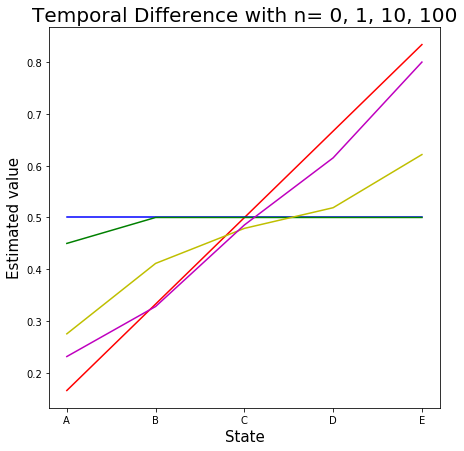

In [145]:
plt.figure(1, figsize=(7,7))
plt.title('Temporal Difference with n= 0, 1, 10, 100', fontsize=20)
plt.plot(*x_y_from_values(values_MRP), 'r', *x_y_from_values(values_TD[0]), 'b',
        *x_y_from_values(values_TD[1]), 'g', *x_y_from_values(values_TD[2]), 'y',
        *x_y_from_values(values_TD[3]), 'm')
plt.xlabel('State', fontsize=15)
plt.ylabel('Estimated value', fontsize=15)
plt.show()

## N=1 일때 그래프가 초록색처럼 그려지는 이유?
TD learning에 사용된 example이 왼쪽 terminal state에서 0의 reward를 받고 끝났기때문. 

In [146]:
from collections import defaultdict
values_MC = defaultdict(list)
for alpha in [0.01, 0.02, 0.03, 0.04]:
    MC = MonteCarlo(states, alpha=alpha)
    for n in range(0, 100):
        run = []
        for _ in range(100):
            run.append(root_mean_squared(values_MRP, MC.value_prediction(n)))
        values_MC[alpha].append(sum(run) / len(run))

In [147]:
values_TD = defaultdict(list)
for alpha in [0.05, 0.1, 0.15]:
    TD = TemporalDifference(states, alpha=alpha)
    for n in range(0, 100):
        run = []
        for _ in range(100):
            run.append(root_mean_squared(values_MRP, TD.value_prediction(n)))
        values_TD[alpha].append(sum(run) / len(run))

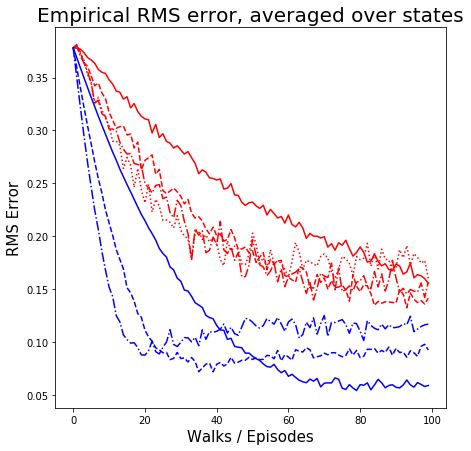

In [148]:
plt.figure(1, figsize=(7,7))
plt.title('Empirical RMS error, averaged over states', fontsize=20)
plt.xlabel('Walks / Episodes', fontsize=15)
plt.ylabel('RMS Error', fontsize=15)
plt.plot(range(100), values_MC[0.01], 'r-')
plt.plot(range(100), values_MC[0.02], 'r--')
plt.plot(range(100), values_MC[0.03], 'r-.')
plt.plot(range(100), values_MC[0.04], 'r:')

plt.plot(range(100), values_TD[0.05], 'b-')
plt.plot(range(100), values_TD[0.1], 'b--')
plt.plot(range(100), values_TD[0.15], 'b-.')
plt.show()

## TD learning with $\alpha$=0.1 에서 episode가 많을수록 error가 높아지는 이유는?
$\alpha$값이 클 경우 최근에 사용된 example에 과다한 가중치를 부여하게 된다. 따라서 $v_\pi$ 값에서 멀어지는 추정치를 얻게될 가능성이 커진다.
